In [2]:
# trend_prediction_sber.py
"""
Модернизированный проект: Предсказание тренда на временных рядах (SBER)
Автор: Полина Круглова
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, RepeatVector, Conv1D, MaxPooling1D)
from tensorflow.keras.optimizers import Adam
from pylab import rcParams
import warnings

import os
import gdown


warnings.filterwarnings('ignore')
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)



# === Загрузка и подготовка данных ===


if not os.path.exists('SBER_MIN60.txt'):
    print("📥 Скачивание файла SBER_MIN60.txt...")
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/SBER_MIN60.txt', 'SBER_MIN60.txt', quiet=False)

COL_DATE = 'Datetime'
COL_CLOSE = 'Close'
TIME_RANGE = ('2010-09-01 10:00:00.000', '2018-12-31 23:59:00.000')
INDICATOR_DEPTH = 14
SEQ_LEN = 19
PREDICT_LAG = 1
TEST_LEN = 600
CLASS_LABELS = ['Нисходящий/боковой', 'Восходящий']

print("\n🔄 Загрузка и подготовка данных...")
data = pd.read_csv('SBER_MIN60.txt', sep="\t", names=['Datetime', 'Open', 'High', 'Low', 'Close'])
data.index = pd.to_datetime(data[COL_DATE])
data.drop(columns=COL_DATE, inplace=True)
data = data[(data.index >= TIME_RANGE[0]) & (data.index <= TIME_RANGE[1])]

# Построение индикаторов относительной доходности
for i in range(1, INDICATOR_DEPTH + 1):
    data[f'Close_chng_{i}'] = data[COL_CLOSE].pct_change(i)
data.dropna(inplace=True)

# Построение бинарных индикаторов тренда
data[[f'Y_{i}' for i in range(1, INDICATOR_DEPTH + 1)]] = (data[[f'Close_chng_{i}' for i in range(1, INDICATOR_DEPTH + 1)]] > 0).astype(float)

# Формирование признаков и целевой переменной
x_columns = [COL_CLOSE] + [f'Y_{i}' for i in range(1, INDICATOR_DEPTH + 1)]
x_data = data[x_columns].values
y_data = to_categorical(data[f'Y_{INDICATOR_DEPTH}'])

# Нормализация и разделение
x_train_data, y_train_data = x_data[:-TEST_LEN-SEQ_LEN], y_data[:-TEST_LEN-SEQ_LEN]
x_test_data, y_test_data = x_data[-TEST_LEN:], y_data[-TEST_LEN:]
x_scaler = StandardScaler()
x_train_data = x_scaler.fit_transform(x_train_data)
x_test_data = x_scaler.transform(x_test_data)

print("✅ Данные подготовлены")


📥 Скачивание файла SBER_MIN60.txt...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l11/SBER_MIN60.txt
To: /content/SBER_MIN60.txt
2.17MB [00:00, 2.70MB/s]



🔄 Загрузка и подготовка данных...
✅ Данные подготовлены


In [3]:
# === Формирование обучающих и тестовых выборок ===
def split_sequence(x_data, y_data, seq_len, predict_lag):
    """Формирует входные и выходные выборки для обучения модели"""
    x_len = x_data.shape[0] - seq_len - (predict_lag - 1)
    x = [x_data[i:i + seq_len] for i in range(x_len)]
    y = [y_data[i + seq_len + predict_lag - 1] for i in range(x_len)]
    return np.array(x), np.array(y)

x_train, y_train = split_sequence(x_train_data, y_train_data, SEQ_LEN, PREDICT_LAG)
x_test, y_test = split_sequence(x_test_data, y_test_data, SEQ_LEN, PREDICT_LAG)

print("✅ Обучающая и тестовая выборки сформированы")

# === Архитектура модели ===
input_layer = Input(shape=x_train.shape[1:])
features = Flatten()(input_layer)
features = RepeatVector(4)(features)
features = Conv1D(SEQ_LEN * 2, 5, padding='same', activation='relu')(features)
features = MaxPooling1D(pool_size=2)(features)
features = Flatten()(features)
features = RepeatVector(4)(features)
features = Conv1D(SEQ_LEN, 5, padding='same', activation='relu')(features)
features = MaxPooling1D(pool_size=2)(features)
features = Flatten()(features)
features = Dense(SEQ_LEN * 100, activation='relu')(features)
features = Dropout(0.4)(features)
output_layer = Dense(y_train.shape[1], activation='sigmoid')(features)

model = Model(input_layer, output_layer)
print("✅ Модель построена")

✅ Обучающая и тестовая выборки сформированы
✅ Модель построена


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 285)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 4, 285)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 38)          │        54,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 38)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 4, 76)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 19)          │         7,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1900)           │        74,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         3,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,329 (544.25 KB)

 Trainable params: 139,329 (544.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8666 - loss: 0.3349 - val_accuracy: 0.9484 - val_loss: 0.1553
Epoch 2/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9280 - loss: 0.2006 - val_accuracy: 0.9501 - val_loss: 0.1598
Epoch 3/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9274 - loss: 0.1996 - val_accuracy: 0.9518 - val_loss: 0.1516
Epoch 4/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9289 - loss: 0.1900 - val_accuracy: 0.9552 - val_loss: 0.1603
Epoch 5/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9354 - loss: 0.1828 - val_accuracy: 0.9466 - val_loss: 0.1549
Epoch 6/6
568/568 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9375 - loss: 0.1750 - val_accuracy: 0.9466 - val_loss: 0.1598


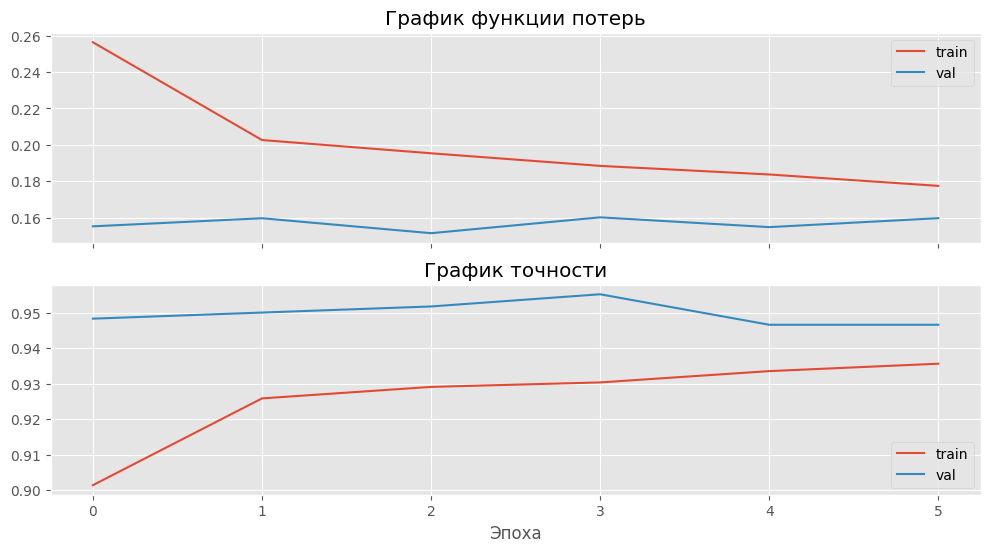

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


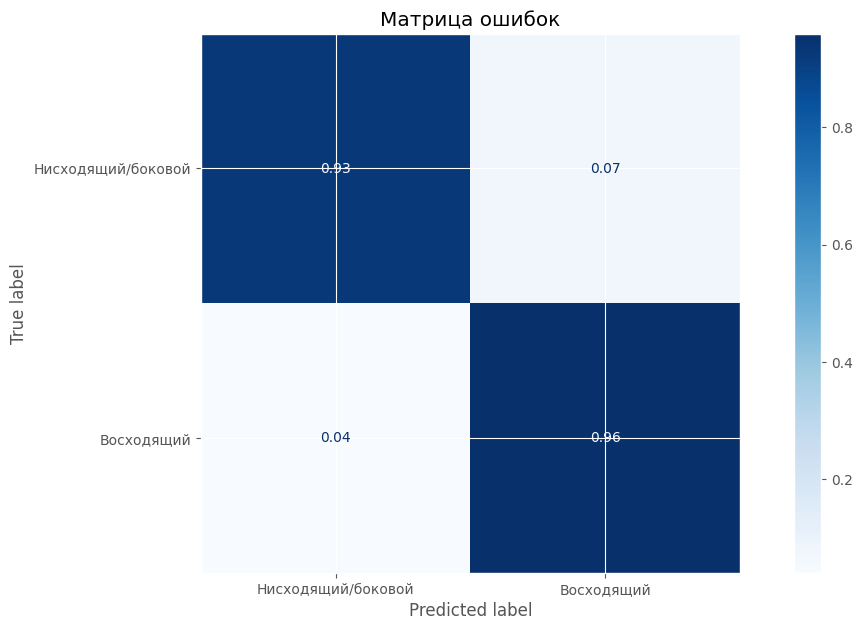

In [4]:
# === Обучение и визуализация результатов ===
def train_eval_model(model, x_train, y_train, x_test, y_test, title='Модель предсказания тренда'):
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test), verbose=1)

    # Графики обучения
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax1.set_title('График функции потерь')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.legend()

    ax2.set_title('График точности')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.legend()
    plt.xlabel('Эпоха')
    plt.show()

    # Матрица ошибок
    y_pred = model.predict(x_test)
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=CLASS_LABELS)
    disp.plot(cmap='Blues')
    plt.title('Матрица ошибок')
    plt.show()

train_eval_model(model, x_train, y_train, x_test, y_test)
